In [1]:

import numpy as np
import torch
from pathlib import Path
from hydra.utils import to_absolute_path
from scipy.ndimage import binary_dilation, label

Original Signal:
tensor([1., 2., 3., 4.])

Zero-Padded Signal:
tensor([1., 2., 3., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

RFFT Original Result (Complex Frequencies):
tensor([10.+0.j, -2.+2.j, -2.+0.j])

RFFT Result (Complex Frequencies):
tensor([10.0000+0.0000j,  9.4966-2.7915j,  8.0622-5.2084j,  5.9108-6.9361j,
         3.3595-7.7695j,  0.7759-7.6442j, -1.4822-6.6435j, -3.1242-4.9807j,
        -3.9717-2.9596j, -3.9833-0.9215j, -3.2555+0.8137j, -2.0000+2.0000j,
        -0.5014+2.5041j,  0.9358+2.3224j,  2.0426+1.5749j,  2.6318+0.4771j,
         2.6283-0.7046j,  2.0780-1.7053j,  1.1330-2.3117j,  0.0184-2.4016j,
        -1.0147-1.9645j, -1.7397-1.1011j, -2.0000+0.0000j])


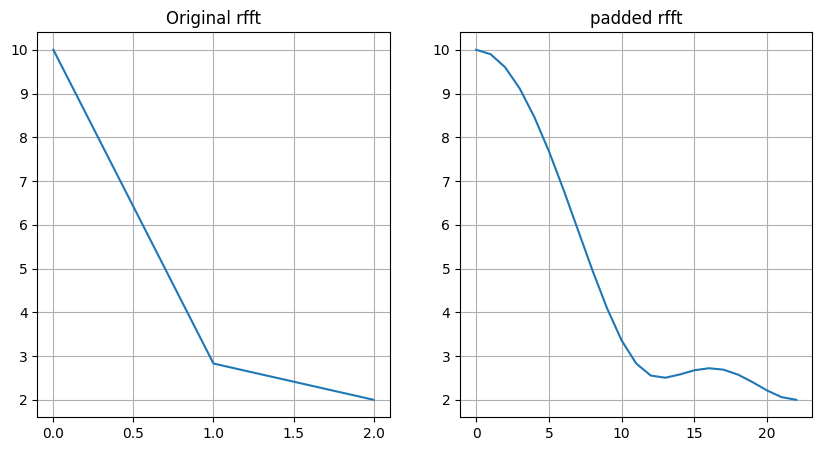

In [ ]:
import torch
import matplotlib.pyplot as plt

# Original 1D signal (simple sine wave)
x = torch.tensor([1.0, 2.0, 3.0, 4.0])

# Zero padding to length 8
x_padded = torch.cat([x, torch.zeros(40)])

# Perform rfft on the padded signal
rfft_original = torch.fft.rfft(x)
rfft_result = torch.fft.rfft(x_padded)

print("Original Signal:")
print(x)

print("\nZero-Padded Signal:")
print(x_padded)

print("\nRFFT Original Result (Complex Frequencies):")
print(rfft_original)

print("\nRFFT Result (Complex Frequencies):")
print(rfft_result)

# Plot the magnitude spectrum of the original and zero-padded FFTs
plt.figure(figsize=(10, 5))

# Plot the original signal rfft without padding
plt.subplot(1, 2, 1)
plt.plot(torch.abs(rfft_original).numpy(), label="Original rfft")
plt.title("Original rfft")
plt.grid()

# Plot the magnitude spectrum of the zero-padded signal
plt.subplot(1, 2, 2)
plt.plot(torch.abs(rfft_result).numpy(), label="padded rfft")
plt.title("padded rfft")
plt.grid()

plt.show()




In [25]:
field_name = "density"
num_channels = 1

#order of raw fields: density, velocity_x, velocity_y

base_folder = "Datasets/final_combined_dataset_for_train"
Re_list = [200,300,400]
data = torch.empty([0,num_channels,1024,256])

In [26]:
#load the obsmask
mask = torch.load("Datasets/final_combined_dataset_for_train/obs_mask.pt", weights_only=True)

In [27]:
print(mask.shape)

torch.Size([1, 1024, 256])


In [28]:
for Re in Re_list:
    data_file = f"{field_name}_Re_{Re}.pt"
    #join the path with the base folder
    data_file_path = Path(base_folder).joinpath(data_file)
    loaded_data = torch.load(data_file_path)
    loaded_data = loaded_data[350:]
    data = torch.cat([data, loaded_data], dim=0)

/tmp/ipykernel_3557515/3221829660.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(data_file_path)


In [29]:
print(data.shape)
print(mask.shape)

torch.Size([1953, 1, 1024, 256])
torch.Size([1, 1024, 256])


In [30]:
#np.savetxt("mask.txt", mask[0, :, :] , delimiter=", ", fmt='%.3f')

In [31]:
#multiply the data with the mask
mask = mask.repeat(data.shape[0],1,1,1)
print(mask.shape)

torch.Size([1953, 1, 1024, 256])


In [32]:
original_data = data
data = data * mask   #masking is required to find the boundarz of the cylinder
print(data.shape)

torch.Size([1953, 1, 1024, 256])


In [33]:
#np.savetxt("masked_density_re_300_timestep_350.txt", data[0, 0, :, :] , delimiter=", ", fmt='%.5f')

In [34]:


# Dilate the mask to find boundary (this will create a region around obstacles)
dilated_mask = binary_dilation(mask.numpy())

# Identify the boundary by subtracting the obstacle mask from the dilated mask
boundary_mask = dilated_mask & ~mask.numpy()



In [35]:
print(dilated_mask.shape)
#np.savetxt("dilated_mask_re_300_timestep_350.txt", dilated_mask[0, 0, :, :] , delimiter=", ", fmt='%.3f')
#np.savetxt("boundary_mask_re_300_timestep_350.txt", boundary_mask[0, 0, :, :] , delimiter=", ", fmt='%.3f')

(1953, 1, 1024, 256)


In [36]:
print(boundary_mask.shape)

(1953, 1, 1024, 256)


In [37]:
def average_neighbor_density(density, boundary_mask):
    avg_density = np.zeros_like(density)
    #print(density.shape)
    # Get the indices of the boundary
    boundary_indices = np.argwhere(boundary_mask)

    #print(boundary_indices) #3d index 

    for idx in boundary_indices:
        i, j = idx[1], idx[2]
        
        # Extract neighboring values (considering a 3x3 window)
        neighbors = density[0, max(i-1, 0):min(i+2, density.shape[1]),
                            max(j-1, 0):min(j+2, density.shape[2])]

        # Exclude zero values (obstacle cells)
        valid_neighbors = neighbors[neighbors != 0]

        # Calculate the average of valid neighbors
        if valid_neighbors.shape[0]> 0:
            avg_density[0, i, j] = torch.mean(valid_neighbors)
        else:
            avg_density[0, i, j] = 0  # or some default value

    return torch.tensor(avg_density)

In [38]:
# Fill the boundary with the average density
for i in range(data.shape[0]): #loop over the timesteps
    average_density_array= average_neighbor_density(data[i], boundary_mask[i])

    for idx in np.argwhere(boundary_mask[i]):
        j, k = idx[1], idx[2]
        data[i, 0, j, k] = average_density_array[0, j, k]

In [39]:
#np.savetxt("boundary_after_averaging_re_300_timestep_350.txt", average_density_array[ 0, :, :] , delimiter=", ", fmt='%.4f')
#np.savetxt("density_after_averaging_re_300_timestep_350.txt", data[0, 0, :, :] , delimiter=", ", fmt='%.4f')

In [40]:
##### Copy the density values into the walls
new_density_array = np.zeros((data.shape[0], data.shape[1], data.shape[2]+2, data.shape[3]+2))

# Copy the original array into the middle of the new array
new_density_array[:, :, 1:-1, 1:-1] = data

# Copy the boundaries
# Top and bottom rows
new_density_array[:, :, 0, 1:-1] = data[:, :, 0, :]
new_density_array[:, :, -1, 1:-1] = data[:, :, -1, :]

# Left and right columns
new_density_array[:, :, 1:-1, 0] = data[:, :, :, 0]
new_density_array[:, :, 1:-1, -1] = data[:, :, :, -1]

# Corners
new_density_array[:, :, 0, 0] = data[:, :, 0, 0]        # Top-left
new_density_array[:, :, 0, -1] = data[:, :, 0, -1]      # Top-right
new_density_array[:, :, -1, 0] = data[:, :, -1, 0]      # Bottom-left
new_density_array[:, :, -1, -1] = data[:, :, -1, -1]    # Bottom-right

print(new_density_array.shape)  # Should print (100, 1, 1026, 258)


(1953, 1, 1026, 258)


In [41]:
#take the gradient of the density field using 
dx = 0.0001953125

grad_height = np.gradient(new_density_array, dx, axis=2) #across the rows (height)

# Gradient along the width (axis 3)
grad_width = np.gradient(new_density_array, dx, axis=3) #across the columns (width)

# Stack the gradients into a new array with shape [100, 2, 1026, 258]
# The first channel (index 1) will be the height gradient, the second (index 2) will be the width gradient
# We extract the first component from grad_height and grad_width since they return arrays of the same shape
spatial_gradients = np.concatenate((grad_height, grad_width), axis=1)
print(spatial_gradients.shape)  # Should print (100, 2, 1026, 258)

#discard the boundaries from the spatial gradient
spatial_gradients = spatial_gradients[:, :, 1:-1, 1:-1]

print(spatial_gradients.shape)  

(1953, 2, 1026, 258)
(1953, 2, 1024, 256)


In [42]:
print(mask.shape)

torch.Size([1953, 1, 1024, 256])


In [43]:
#apply the mask to the spatial gradients
spatial_gradients_masked = spatial_gradients * mask.numpy()

In [19]:
# np.savetxt("masked_grad_feature_x.txt", spatial_gradients_masked[0, 0, :, :] , delimiter=",", fmt='%.2d')
# np.savetxt("masked_grad_feature_y.txt", spatial_gradients_masked[0, 1, :, :], delimiter=",", fmt='%.2d')

In [44]:
#Remove the first 25 rows from the inlet
spatial_gradients_masked = spatial_gradients_masked[:, :, 24:, :]
print(spatial_gradients_masked.shape)

(1953, 2, 1000, 256)


In [53]:
#removed the first 25 rows
# np.savetxt("cropped_masked_grad_feature_x.txt", spatial_gradients_masked[1939, 0, :, :] , delimiter=",", fmt='%.2d')
# np.savetxt("cropped_masked_grad_feature_y.txt", spatial_gradients_masked[0, 1, :, :], delimiter=",", fmt='%.2d')

In [ ]:
#print the max and min value of the spatial gradients
print('for grad_rho (along the height)')
print(np.max(spatial_gradients_masked[:, 0:1, :, :]))
print(np.min(spatial_gradients_masked[:, 0:1, :, :]))
# find the indices of the max and min values
max_indices = np.unravel_index(np.argmax(spatial_gradients_masked[:, 0:1, :, :]), spatial_gradients_masked[:, 0:1, :, :].shape)
min_indices = np.unravel_index(np.argmin(spatial_gradients_masked[:, 0:1, :, :]), spatial_gradients_masked[:, 0:1, :, :].shape)
print(max_indices)
print(min_indices)

print('for grad_rho (along the width)')
print(np.max(spatial_gradients_masked[:, 1:2, :, :]))
print(np.min(spatial_gradients_masked[:, 1:2, :, :]))
# find the indices of the max and min values
max_indices = np.unravel_index(np.argmax(spatial_gradients_masked[:, 1:2, :, :]), spatial_gradients_masked[:, 1:2, :, :].shape)
min_indices = np.unravel_index(np.argmin(spatial_gradients_masked[:, 1:2, :, :]), spatial_gradients_masked[:, 1:2, :, :].shape)
print(max_indices)
print(min_indices)



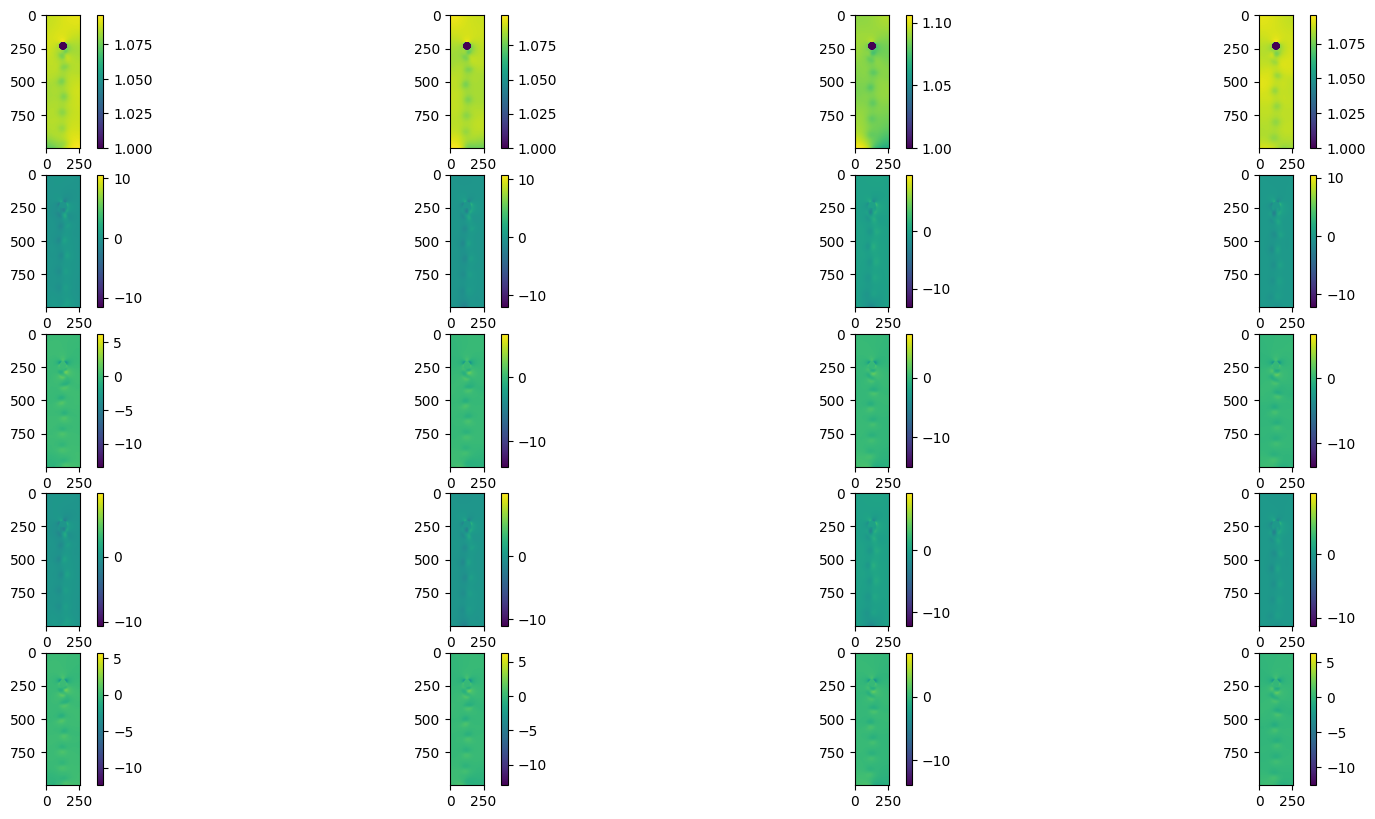

In [45]:
#plot the first 4 images
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 4, figsize=(20, 10))
for idx, i in enumerate(range(350, 354)):
    im = axs[0, idx].imshow(original_data[i, 0, 24:, :].cpu().detach().numpy()*mask[i, 0, 24:, :].numpy(), cmap='viridis', vmin=1)
    im2 = axs[1, idx].imshow(spatial_gradients_masked[i, 1, :, :], cmap='viridis') # only gradient along the width
    im3 = axs[2, idx].imshow(spatial_gradients_masked[i, 0, :, :], cmap='viridis') # only gradient along the height
    im4 = axs[3, idx].imshow((spatial_gradients_masked[i, 1, :, :] / original_data[i, 0, 24:, :].cpu().detach().numpy())*mask[i, 0, 24:, :].numpy(), cmap='viridis') # rho_gradient/rho along the width of the channel
    im5 = axs[4, idx].imshow((spatial_gradients_masked[i, 0, :, :] / original_data[i, 0, 24:, :].cpu().detach().numpy())*mask[i, 0, 24:, :].numpy(), cmap='viridis') # rho_gradient/rho along the height of the channel
    
    # axs[i].axis('off')
    fig.colorbar(im, ax=axs[0, idx])
    fig.colorbar(im2, ax=axs[1, idx])
    fig.colorbar(im3, ax=axs[2, idx])
    fig.colorbar(im4, ax=axs[3, idx])
    fig.colorbar(im5, ax=axs[4, idx])
plt.show()

In [46]:
feature_y = (spatial_gradients_masked[:, 1:2, :, :] / (original_data[:, 0:1, 24:, :].cpu().detach().numpy())) # spatial gradient along the width
feature_x = (spatial_gradients_masked[:, 0:1, :, :] / (original_data[:, 0:1, 24:, :].cpu().detach().numpy())) # spatial gradient along the height
print(feature_y.shape)
print(feature_x.shape)

(1953, 1, 1000, 256)
(1953, 1, 1000, 256)


In [47]:
print('for feature_x: grad_rho/rho along the height')
print(np.max(feature_x))
print(np.min(feature_x))
# find the indices of the max and min values
max_indices_feature_x = np.unravel_index(np.argmax(feature_x), feature_x.shape)
min_indices_feature_x = np.unravel_index(np.argmin(feature_x), feature_x.shape)
print(max_indices_feature_x)
print(min_indices_feature_x)

print('for feature_y: grad_rho/rho along the width')
print(np.max(feature_y))
print(np.min(feature_y))

# find the indices of the max and min values
max_indices_feature_y = np.unravel_index(np.argmax(feature_y), feature_y.shape)
min_indices_feature_y = np.unravel_index(np.argmin(feature_y), feature_y.shape)
print(max_indices_feature_y)
print(min_indices_feature_y)

for feature_x: grad_rho/rho along the height
7.839606026818527
-15.220156575031954
(1502, 0, 220, 151)
(1663, 0, 217, 150)
for feature_y: grad_rho/rho along the width
12.829671011900226
-12.830715707929038
(1392, 0, 209, 113)
(1668, 0, 209, 142)


In [48]:
grad_feature = np.concatenate((feature_x, feature_y), axis=1)
print(grad_feature.shape)

(1953, 2, 1000, 256)


In [49]:
np.savetxt("feature_x.txt", feature_x[1700, 0, :, :] , delimiter=",", fmt='%.2f')
np.savetxt("feature_y.txt", feature_y[1700, 0, :, :], delimiter=",", fmt='%.2f')

In [ ]:
mean_of_density_grad = np.mean(grad_feature, axis = (0,2,3))
std_of_density_grad= np.std(grad_feature, axis = (0,2,3))

print(mean_of_density_grad)
print(std_of_density_grad)

# Stats for grad_rho/rho 

In [ ]:
"""
For Re from 200 to 400, the mean and std of the grad_density/density  for grid resolution "1000x256":

mean: [-0.01770596 -0.00016272]  (across the rows (height-->1000 rows) , across the columns (width-->256 cols))
std: [0.33780711 0.39969117]
"""

"""
For Re from 100 to 500, the mean and std of the grad_density/density  for grid resolution 1000x256:

mean: [-0.01835937 -0.00012925]
std: [0.33422084 0.39361019] 
"""

1000
1000


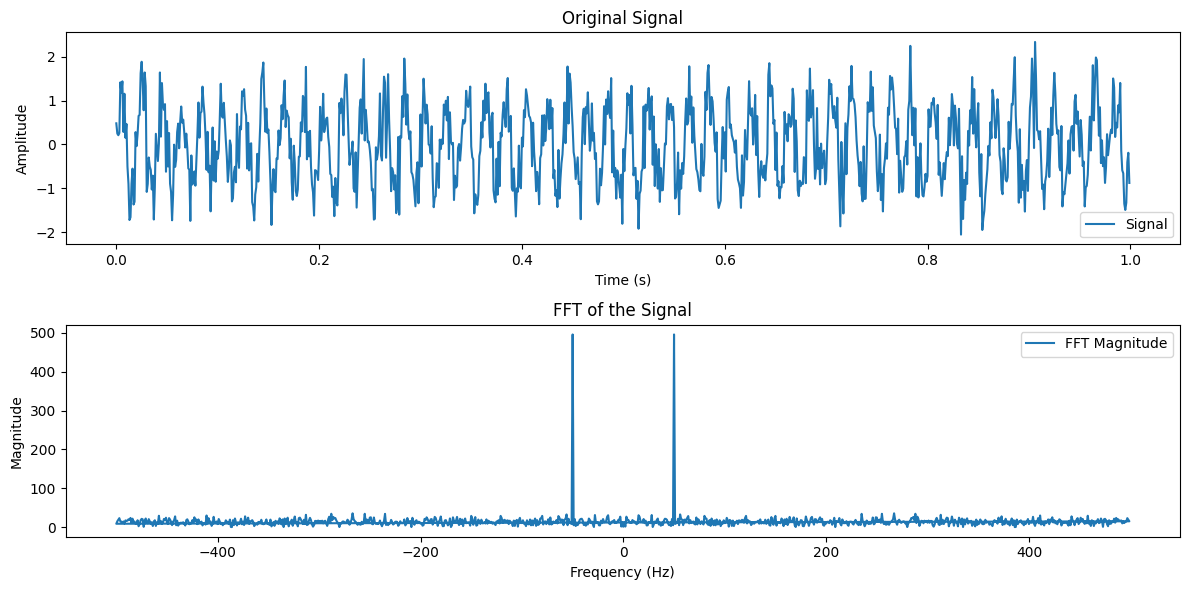

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 1D signal (e.g., a sine wave with some noise)
sampling_rate = 1000  # Hz
T = 1.0 / sampling_rate  # Sampling interval
t = np.linspace(0.0, 1.0, sampling_rate, endpoint=False)  # 1 second duration
freq = 50.0  # Frequency of the sine wave in Hz
signal = np.sin(2.0 * np.pi * freq * t) + 0.5 * np.random.normal(size=t.shape)

# Perform FFT
fft_result = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), T)

print(len(signal))
print(len(fft_result))


# Use only the positive half of the spectrum
half_n = len(signal) // 2
fft_magnitude = np.abs(fft_result[:])
positive_freqs = fft_freqs[:]

# Plot the signal and its FFT
plt.figure(figsize=(12, 6))

# Original signal
plt.subplot(2, 1, 1)
plt.plot(t, signal, label="Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# FFT result
plt.subplot(2, 1, 2)
plt.plot(positive_freqs, fft_magnitude, label="FFT Magnitude")
plt.title("FFT of the Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.show()


1000
501


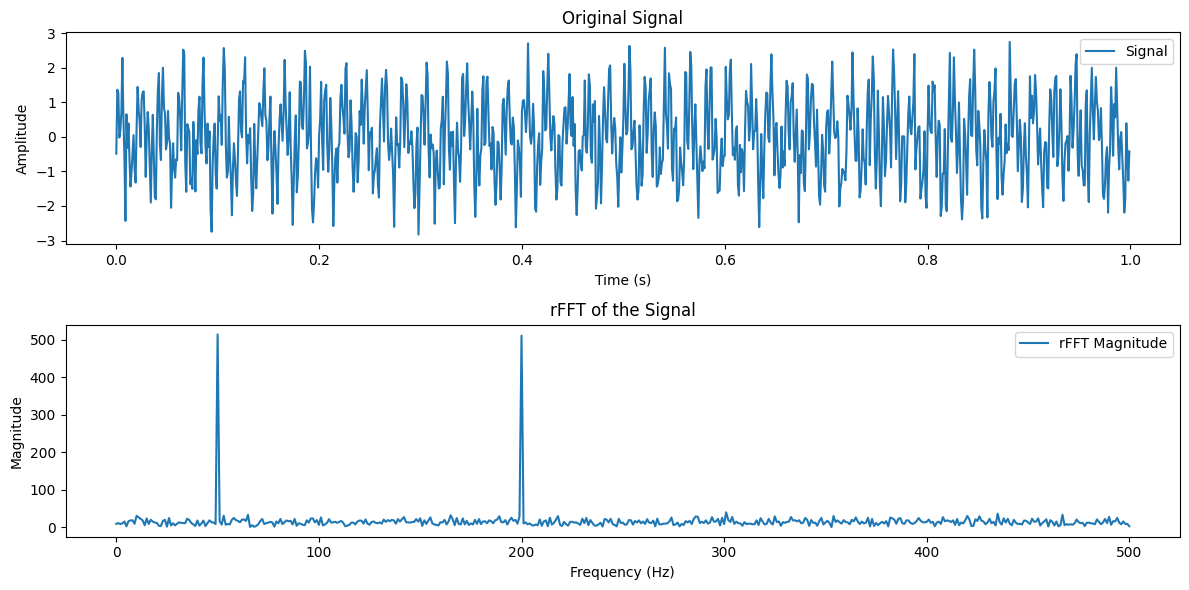

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a real-valued signal (e.g., a sine wave with some noise)
sampling_rate = 1000  # Hz
T = 1.0 / sampling_rate  # Sampling interval
t = np.linspace(0.0, 1.0, sampling_rate, endpoint=False)  # 1-second duration
freq = 50.0  # Frequency of the sine wave in Hz
signal = np.sin(2.0 * np.pi * freq * t) + 0.5 * np.random.normal(size=t.shape) + np.sin(2.0 * np.pi * 200 * t)


# Perform rFFT
rfft_result = np.fft.rfft(signal)
rfft_freqs = np.fft.rfftfreq(len(signal), T)

print(len(signal))
print(len(rfft_result))
# Magnitude of the FFT
rfft_magnitude = np.abs(rfft_result)

# Plot the original signal and its rFFT
plt.figure(figsize=(12, 6))

# Original signal
plt.subplot(2, 1, 1)
plt.plot(t, signal, label="Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# rFFT result
plt.subplot(2, 1, 2)
plt.plot(rfft_freqs, rfft_magnitude, label="rFFT Magnitude")
plt.title("rFFT of the Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid with a sinusoidal pattern
N = 4  # Grid size
x = np.linspace(0, 4 * np.pi, N)
y = np.linspace(0, 4 * np.pi, N)
X, Y = np.meshgrid(x, y)
signal = np.sin(X) + np.sin(Y)

print("original signal")
print(signal)

# Perform the 2D FFT
fft_result = np.fft.fft2(signal)
#fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency to the center
magnitude = np.abs(fft_result)  # Get the magnitude

print("fft result")
print(fft_result)

# Plot the original signal
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.title("Original Signal")
# plt.imshow(signal, extent=(0, 4 * np.pi, 0, 4 * np.pi), cmap='viridis')
# plt.colorbar(label="Amplitude")
# plt.xlabel("X")
# plt.ylabel("Y")

# # Plot the magnitude of the FFT
# plt.subplot(1, 2, 2)
# plt.title("2D FFT Magnitude Spectrum")
# plt.imshow(np.log(1+magnitude), cmap='inferno')  # Use log scale for better visibility
# plt.colorbar(label="Log Magnitude")
# plt.xlabel("Frequency X")
# plt.ylabel("Frequency Y")

# plt.tight_layout()
#plt.show()


original signal
[[ 0.00000000e+00 -8.66025404e-01  8.66025404e-01 -4.89858720e-16]
 [-8.66025404e-01 -1.73205081e+00  7.77156117e-16 -8.66025404e-01]
 [ 8.66025404e-01  7.77156117e-16  1.73205081e+00  8.66025404e-01]
 [-4.89858720e-16 -8.66025404e-01  8.66025404e-01 -9.79717439e-16]]
fft result
[[ 3.10862447e-15+0.j         -3.46410162e+00+3.46410162j
   6.92820323e+00+0.j         -3.46410162e+00-3.46410162j]
 [-3.46410162e+00+3.46410162j  1.11022302e-16+0.j
   2.22044605e-16+0.j         -1.11022302e-16+0.j        ]
 [ 6.92820323e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [-3.46410162e+00-3.46410162j -1.11022302e-16+0.j
   2.22044605e-16+0.j          1.11022302e-16+0.j        ]]


In [31]:
x = [-8.66025404e-01, -1.73205081e+00,  7.77156117e-16, -8.66025404e-01]
#do fft on the x
rfft_result = np.fft.rfft(x)
print(rfft_result)

[-3.46410162+0.j         -0.8660254 +0.86602541j  1.73205081+0.j        ]
